In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as cx
import momepy
import networkx as nx
import shapely
from cityseer.tools import io, graphs, plot
from cityseer.metrics import networks, layers

c:\Users\Alexander\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
NVT_SNELHEID = 80

In [56]:
def remove_node_reattached(node, g, geom_name='geometry'):
    edges = list(g.edges(node))

    if len(edges) != 2:
        # print('warning: node passed with not-2 degree, ignored')
        return
    
    a1, b1 = edges[0]
    a2, b2 = edges[1]
    
    e1 = a1 if a1 != node else b1
    e2 = a2 if a2 != node else b2

    # create new edge with new geometry (straight line)
    # TODO: if possible, reconstruct geometry using old linestring

    geo1 = g[a1][b1][geom_name]
    geo2 = g[a2][b2][geom_name]
    geo_merged = shapely.ops.linemerge(shapely.geometry.MultiLineString([geo1, geo2]))

    g.add_edge(e1, e2, 
               length=g[a1][b1]['length'] + g[a2][b2]['length'],
               wegnr=g[a1][b1]['wegnr'],
               maxshd=min(g[a1][b1]['maxshd'], g[a2][b2]['maxshd']))
    g[e1][e2][geom_name] = geo_merged
    # g.add_edge(e1, e2)
    g.remove_node(node)

def remove_degree2(new, original, geom_name='geometry'):
    # all degree 2 nodes to be removed
    to_remove = [node for node, degree in original.degree if degree == 2]
    for node_remove in to_remove:
        remove_node_reattached(node_remove, new, geom_name=geom_name)


In [26]:
df_friesland = gpd.read_file("friesland.shp")
df_friesland.geometry = momepy.close_gaps(df_friesland, 3)
graph = momepy.gdf_to_nx(df_friesland, approach="primal")
graph = nx.Graph(graph)

simplified_graph = graph.subgraph(max(nx.connected_components(graph), key=len)).copy()

# only store WEGNR and length as attributes
for e in simplified_graph.edges:
    data = simplified_graph.get_edge_data(*e)
    wegnr = data['WEGNUMMER']
    maxshd = data['MAXSHD']
    maxshd = int(maxshd) if maxshd != 'NVT' and maxshd != 'NOA' else NVT_SNELHEID
    length = data['LENGTE']
    geometry = data['geometry']
    data.clear()
    nx.set_edge_attributes(simplified_graph, {e: {'wegnr': wegnr, 'length': length, 'geometry': geometry, 'maxshd': maxshd }})

remove_degree2(simplified_graph, graph)
print(simplified_graph)

Graph with 1621 nodes and 2081 edges


In [27]:
graph_gdp = momepy.nx_to_gdf(simplified_graph, points=False)
graph = io.nx_from_generic_geopandas(graph_gdp)
print(graph)

  0%|          | 0/2081 [00:00<?, ?it/s]

100%|██████████| 2081/2081 [00:00<00:00, 2831.32it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 1.
100%|██████████| 2081/2081 [00:00<00:00, 123255.62it/s]

MultiGraph with 1621 nodes and 2081 edges


In [19]:
# plot.plot_nx(graph)

In [59]:
graph2 = graphs.nx_split_opposing_geoms(
    graph,
    buffer_dist=450, # 250, 50
)
graph2 = graphs.nx_consolidate_nodes(
    graph2,
    buffer_dist=500,
    crawl=True,
    prioritise_by_hwy_tag=True,
)
graph2 = graphs.nx_merge_parallel_edges(
    graph2,
    merge_edges_by_midline=True,
    contains_buffer_dist=450 # 250, 50
)
graph2 = graphs.nx_consolidate_nodes(
    graph2,
    buffer_dist=1200, # 1200
    crawl=True,
    prioritise_by_hwy_tag=True,
)

print(f"{len(graph2.nodes)=} {len(graph2.edges)=}")

INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 2081/2081 [00:00<00:00, 3040.44it/s]
INFO:cityseer.tools.graphs:Splitting opposing edges.
100%|██████████| 1621/1621 [00:04<00:00, 361.49it/s]
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
100%|██████████| 3984/3984 [00:01<00:00, 2015.62it/s]
INFO:cityseer.tools.util:Creating nodes STR tree
100%|██████████| 1621/1621 [00:00<00:00, 4705167.32it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|██████████| 1621/1621 [00:01<00:00, 866.24it/s] 
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
100%|██████████| 801/801 [00:00<00:00, 2018.24it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 450.
100%|██████████| 782/782 [00:04<00:00, 189.11it/s]
INFO:cityseer.tools.util:Creating nodes STR tree
100%|██████████| 399/399 [00:00<00:00, 49462.89it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|████

len(graph2.nodes)=257 len(graph2.edges)=291


In [58]:
# TODO: remove degree2 from graph2, only degree2 requires graph and not MultiGraph (and uses other geometry column)

# remove_degree2(graph2, graph2, geom_name='geom')
# print(f"{len(graph2.nodes)=} {len(graph2.edges)=}")

INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.


(6975951.0, 6980951.0)

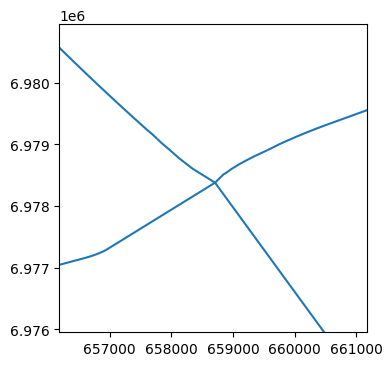

In [60]:
df_friesland_processed = io.geopandas_from_nx(graph2, 3857)
X = 658683
Y = 6978451
buffer = 2500

ax = df_friesland_processed.plot(figsize=(4, 4))
ax.set_xlim(X-buffer, X+buffer)
ax.set_ylim(Y-buffer, Y+buffer)
# cx.add_basemap(ax)

INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges
100%|██████████| 291/291 [00:00<00:00, 139458.69it/s]

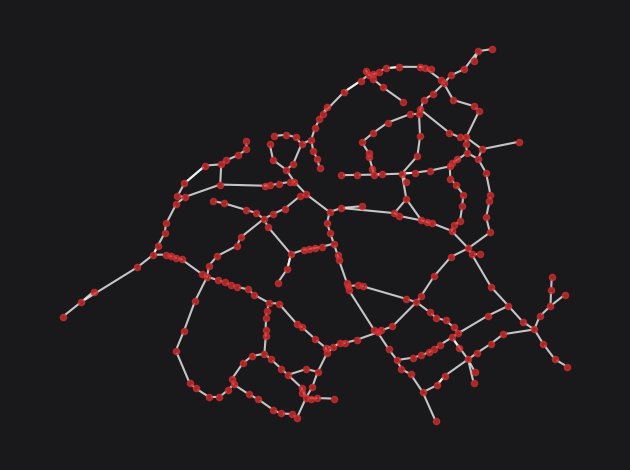

In [61]:
plot.plot_nx(graph2)

In [66]:
df_friesland_processed = io.geopandas_from_nx(graph2, 3857)
for n in ['names', 'routes', 'highways', 'start_nd_key', 'end_nd_key', 'src_edge_i', 'mm_len']:
    df_friesland_processed.drop(n, axis=1, inplace=True)

df_friesland_processed.rename_geometry('geometry', inplace=True) # momepy vindt geom niet leuk

nx_temp = momepy.gdf_to_nx(df_friesland_processed)
(points, lines) = momepy.nx_to_gdf(nx_temp)
points['stad_naam'] = ""
points['is_auto_bron'] = False
points['spawn_hoeveel'] = 0
points.to_file('./wegengraaf2/points.shp')
lines.to_file('./wegengraaf2/lines.shp')

INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
C:\Users\Alexander\AppData\Local\Temp\ipykernel_19364\2503027870.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points.to_file('./wegengraaf2/points.shp')
c:\Users\Alexander\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'is_auto_bron' to 'is_auto_br'
  ogr_write(
c:\Users\Alexander\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'spawn_hoeveel' to 'spawn_hoev'
  ogr_write(
INFO:pyogrio._io:Created 257 records
C:\Users\Alexander\AppData\Local\Temp\ipykernel_19364\2503027870.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  lines.to_file('./wegengraaf2/lines.shp')
c:\Users\Alexander\AppData\Local\Programs\Python\Python311\Lib\site-package